# Pakages

In [1]:
import sys

!{sys.executable} -m pip install numpy
import numpy as np 

!{sys.executable} -m pip install pandas
import pandas as pd

!{sys.executable} -m pip install nltk
import nltk

import warnings
warnings.simplefilter(action='ignore')

#text normalization function
%run ./Text_Normalization_Function.ipynb

[nltk_data] Downloading package stopwords to /Users/Zoeli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Zoeli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Zoeli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Zoeli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

# Load and Clean the Data

In [2]:
reviews = pd.read_csv("Hotel_Reviews.csv")

#Create a column including all the reviews
reviews["reviews"] = reviews["Negative_Review"]+reviews["Positive_Review"]

In [3]:
reviews.Reviewer_Score.describe()
# We found the median of reviewer score is around 8.8 and min is 2.5, indicating total scores tend to be more positive 
# and thus we should pay more attention to the bad reviews.

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

In [4]:
#Create a cloumn called showing whether it is a bad review
#Since it is 10-scale score we set 5 as our breakline.
reviews["is_bad_review"] = reviews["Reviewer_Score"].apply(lambda x: 1 if x<5 else 0)
reviews.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,reviews,is_bad_review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,I am so angry that i made this post available...,1
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,No Negative No real complaints the hotel was g...,0
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Rooms are nice but for elderly a bit difficul...,0


In [5]:
#Select our related columns and form a new dataset out of it.
review_df = reviews[["reviews","is_bad_review"]]
#sample the data
review_df = review_df.sample(frac=0.05,replace=False,random_state=97).reset_index()
review_df.head(5)

,index,reviews,is_bad_review
0,292876,Slow checkin and checkout Many questions and ...,0
1,304351,No Happy atmosphere,0
2,160871,Not enough toiletries for 2 and no slippers ...,0
3,342409,No Negative Very good Hotel at a perfect locat...,0
4,277611,Website said breakfast was included but it wa...,0


In [6]:
import string
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

#Remove the no positive and no negtive data from the dataset
review_df["reviews"] = review_df["reviews"].apply(lambda x: \
                                                  x.replace("No Negative","NA")\
                                                  .replace("No Positive","NA"))

#Defile and clean review function to clean the data, this step includes:
#1. set to lowercase, 2. tokenize 3. split 4.remove stop words 5. Lemmatize 

#Get the pos tag of a word
from nltk.corpus import wordnet
def get_wordnet_pos(pos_tag):
  if pos_tag.startswith('J'):
    return wordnet.ADJ
  elif pos_tag.startswith("V"):
    return wordnet.VERB
  elif pos_tag.startswith("N"):
    return wordnet.NOUN
  elif pos_tag.startswith("R"):
    return wordnet.ADV
  else:
    return wordnet.NOUN

def clean_review(text):
  #lowercase
  text = text.lower()
  #tokenize and punctuation
  text = [word.strip(string.punctuation) for word in text.split(" ")]
  #remove stop words
  stops = stopwords.words("english")
  text = [x for x in text if x not in stops]
  #remove empty tokens
  text = [te for te in text if len(te)>0]
  #we label our text into our labels.
  pos_tags = pos_tag(text)
  #lemmatize our text
  text = [WordNetLemmatizer().lemmatize(t[0],get_wordnet_pos(t[1])) for t in pos_tags]
  #JOIN
  text = " ".join(text)
  return(text)

# Apply clean function
review_df["review_cleaned"] = review_df["reviews"].apply(lambda x: clean_review(x))

In [7]:
review_df = review_df[["is_bad_review","review_cleaned"]]
review_df.head()

,is_bad_review,review_cleaned
0,0,slow checkin checkout many question documentat...
1,0,happy atmosphere
2,0,enough toiletry 2 slipper convenient location ...
3,0,na good hotel perfect location
4,0,website say breakfast include huge deal info c...


## Lexicon Unsupervised Learning

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Zoeli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
review_df["review_cleaned"]
sia = SentimentIntensityAnalyzer() # sentiment intensity analyzer
review_df["sentiment"] = review_df["review_cleaned"].apply(lambda x : sia.polarity_scores(x))
#Combine the sentiment into our dataset
review_df = pd.concat([review_df.drop(['sentiment'],axis=1),review_df["sentiment"].apply(pd.Series)],axis=1)
review_df.head()

,is_bad_review,review_cleaned,neg,neu,pos,compound
0,0,slow checkin checkout many question documentat...,0.0,0.775,0.225,0.4404
1,0,happy atmosphere,0.0,0.213,0.787,0.5719
2,0,enough toiletry 2 slipper convenient location ...,0.0,1.000,0.000,0.0000
3,0,na good hotel perfect location,0.0,0.312,0.688,0.7650
4,0,website say breakfast include huge deal info c...,0.0,0.551,0.449,0.9509


In [10]:
# Define the function for vader lexicon
def analyze_sentiment_vader_lexicon(review, threshold = 0.1, verbose = False):
    scores = sia.polarity_scores(review)  
    is_bad_review = 0 if scores['compound'] >= threshold else 1
    if verbose:                             
        print('VADER Polarity (Binary):', binary_sentiment)
        print('VADER Score:', round(scores['compound'], 2))
    return is_bad_review,scores['compound']  

In [11]:
# Use lexicon method for the first trial without threshold defined. 
 
VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=0.1) \
                       for review in review_df["review_cleaned"]]
VADER_polarity_df = pd.DataFrame(VADER_polarity, columns = ['is_bad_review','VADER Score'])
VADER_polarity_df.head()

,is_bad_review,VADER Score
0,0,0.4404
1,0,0.5719
2,1,0.0000
3,0,0.7650
4,0,0.9509


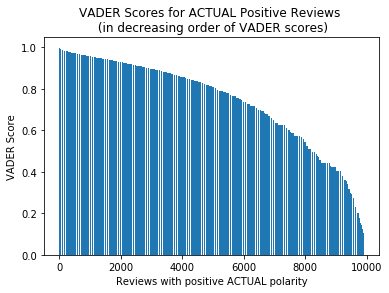

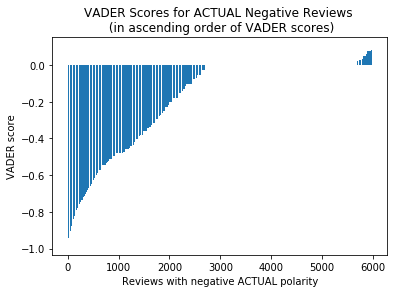

In [12]:
import matplotlib.pyplot as plt

pos_reviews_scored = VADER_polarity_df[VADER_polarity_df["is_bad_review"]==0]['VADER Score'].sample(frac=0.5)
plt.bar(range(0, 9903), pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("Reviews with positive ACTUAL polarity")
plt.ylabel("VADER Score")
plt.title("VADER Scores for ACTUAL Positive Reviews \n (in decreasing order of VADER scores)")
plt.show()

neg_reviews_scored = VADER_polarity_df[VADER_polarity_df["is_bad_review"]==1]['VADER Score']
plt.bar(range(0, 5981), neg_reviews_scored.sort_values(ascending=True))
plt.xlabel("Reviews with negative ACTUAL polarity")
plt.ylabel("VADER score")
plt.title("VADER Scores for ACTUAL Negative Reviews \n (in ascending order of VADER scores)")
plt.show()

### Accuracy Rate

In [13]:
from sklearn import metrics
print('Accuracy Rate:', np.round(metrics.accuracy_score(review_df["is_bad_review"], 
                                 VADER_polarity_df["is_bad_review"]), 3),"\n")

pd.crosstab(pd.Series(review_df["is_bad_review"]), 
            pd.Series(VADER_polarity_df["is_bad_review"]), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Accuracy Rate: 0.777 



Predicted:,0,1,All
True:,,,
0,19352,5291,24643
1,454,690,1144
All,19806,5981,25787


#### The accuracy we get here is 77%. 
#### Precision Rate (For positive reviews): 959/(959+41) =  95.9%
#### Recall Rate (For positive reviews): 959/(959+318) =  75.1%
#### As we can see the result here. The main reason we did not get a more precise result is because that the 
#### threshold we chose is too high, causing some positive results to be negtive(is_bad_review). 


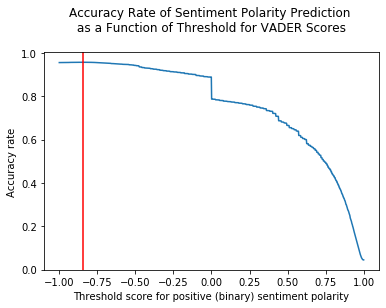

In [14]:
# Use lexicon method for the second trial with threshold defined(only use confound score). 
def try_threshold_for_accuracy(sentiment_scores, threshold_for_pos):
    is_bad_review = [0 if s >= threshold_for_pos else 1 for s in list(sentiment_scores)]
    accuracy = metrics.accuracy_score(review_df["is_bad_review"], is_bad_review)
    return(accuracy) 

thresholds = np.linspace(-1,1,1000)
acc_rates = [try_threshold_for_accuracy(VADER_polarity_df['VADER Score'],threshold) for threshold in thresholds]

optimal_threshold_acc = thresholds[acc_rates.index(max(acc_rates))] 
optimal_threshold_acc
#The optimal threshold when accuracy rate reaches the peak is -0.8458.
#Because based on our dataset, most of the reviews are positive.

plt.plot(thresholds, acc_rates)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("Accuracy rate")
plt.title("Accuracy Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.axvline(optimal_threshold_acc,color="r")
plt.show()

In [15]:
#Then we use the new threshold to get the new model :
VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=optimal_threshold_acc) \
                       for review in review_df["review_cleaned"]]
VADER_polarity_df = pd.DataFrame(VADER_polarity, columns = ['is_bad_review','VADER Score'])

print('Accuracy Rate:', np.round(metrics.accuracy_score(review_df["is_bad_review"], 
                                 VADER_polarity_df["is_bad_review"]), 3),"\n")

pd.crosstab(pd.Series(review_df["is_bad_review"]), 
            pd.Series(VADER_polarity_df["is_bad_review"]), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Accuracy Rate: 0.957 



Predicted:,0,1,All
True:,,,
0,24607,36,24643
1,1069,75,1144
All,25676,111,25787


####  As now we can see the accuray rate is really high, reaching 95.7% and the confusion matrix shows much better results. However, the recall rate performs not so good.

#### When recall rate reached the maximum,precision rate shows a extremely bad experience.

### Recall Rate

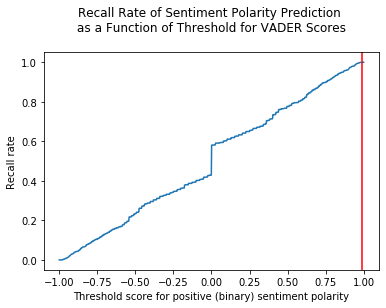

In [16]:
#define recall rate function
def try_threshold_for_recall(sentiment_scores, threshold_for_pos):
    is_bad_review = [0 if s >= threshold_for_pos else 1 for s in list(sentiment_scores)]
    recall = metrics.recall_score(review_df["is_bad_review"], is_bad_review)
    return(recall)  

thresholds = np.linspace(-1,1,1000)
recall_rate = [try_threshold_for_recall(VADER_polarity_df['VADER Score'],threshold) for threshold in thresholds]

#find optimal threshold when recall rate reaches the peak.
optimal_threshold_rr = thresholds[recall_rate.index(max(recall_rate))] 
optimal_threshold_rr
#The optimal threshold when recall rate reaches the peak is 0.98599.

plt.plot(thresholds, recall_rate)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("Recall rate")
plt.title("Recall Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.axvline(optimal_threshold_rr,color="r")
plt.show()

In [17]:
#Then we use the new threshold to get the new model :
VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=optimal_threshold_rr) \
                       for review in review_df["review_cleaned"]]
VADER_polarity_df = pd.DataFrame(VADER_polarity, columns = ['is_bad_review','VADER Score'])

print('Precision Rate:', metrics.recall_score(review_df["is_bad_review"], 
                                 VADER_polarity_df["is_bad_review"]),"\n")

pd.crosstab(pd.Series(review_df["is_bad_review"]), 
            pd.Series(VADER_polarity_df["is_bad_review"]), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Precision Rate: 1.0 



Predicted:,0,1,All
True:,,,
0,250,24393,24643
1,0,1144,1144
All,250,25537,25787


### Precision Rate

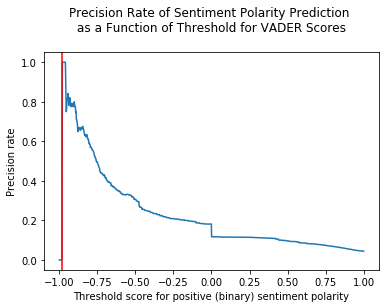

In [18]:
#define precision rate function
def try_threshold_for_precision(sentiment_scores, threshold_for_pos):
    is_bad_review = [0 if s >= threshold_for_pos else 1 for s in list(sentiment_scores)]
    precision = metrics.precision_score(review_df["is_bad_review"], is_bad_review)
    return(precision) 

thresholds = np.linspace(-1,1,1000)
precision_rate = [try_threshold_for_precision(VADER_polarity_df['VADER Score'],threshold) for threshold in thresholds]

#find optimal threshold when precision rate reaches the peak.
optimal_threshold_pr = thresholds[precision_rate.index(max(precision_rate))] 
optimal_threshold_pr

#The optimal threshold when precision rate reaches the peak is around -0.97998.

plt.plot(thresholds, precision_rate)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("Precision rate")
plt.title("Precision Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.axvline(optimal_threshold_pr,color="r")
plt.show()

In [19]:
#Then we use the new threshold to get the new model :
VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=optimal_threshold_pr) \
                       for review in review_df["review_cleaned"]]
VADER_polarity_df = pd.DataFrame(VADER_polarity, columns = ['is_bad_review','VADER Score'])

print('Precision Rate:', metrics.accuracy_score(review_df["is_bad_review"], 
                                 VADER_polarity_df["is_bad_review"]),"\n")

pd.crosstab(pd.Series(review_df["is_bad_review"]), 
            pd.Series(VADER_polarity_df["is_bad_review"]), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Precision Rate: 0.9556753402877419 



Predicted:,0,1,All
True:,,,
0,24643,0,24643
1,1143,1,1144
All,25786,1,25787


#### When precision rate reached the maximum, recall rate shows a extremely bad experience.

### F1 Value(Combine recall rate and precision rate)

####  F1 value is the harmonic mean of precision rate and recall rate. Only when these two rates are both high will F1 value have a high value. The formula of F1 value is (2/F1 value) = (1/precision rate) + (1/recall rate)

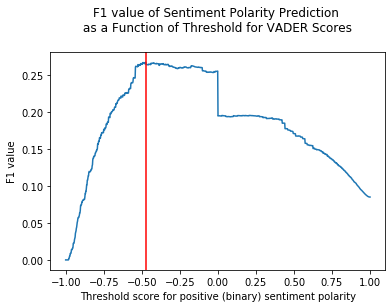

In [20]:
thresholds = np.linspace(-1,1,1000)
f_value=[]

# We define the function of f value
for threshold in thresholds:
    recall_rates = try_threshold_for_recall(VADER_polarity_df['VADER Score'],threshold)
    precision_rates = try_threshold_for_precision(VADER_polarity_df['VADER Score'],threshold)  
    f_value += [2 / ((1/recall_rates) + (1/precision_rates))]
    
optimal_threshold_fv = thresholds[f_value.index(max(f_value))] 
optimal_threshold_fv
# The optimal threshold when recall rate reaches the peak is around -0.47347.

plt.plot(thresholds, f_value)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("F1 value")
plt.title("F1 value of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.axvline(optimal_threshold_fv,color="r")
plt.show()

In [21]:
#Then we use the new threshold to get the new model :
VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=optimal_threshold_fv) \
                       for review in review_df["review_cleaned"]]
VADER_polarity_df = pd.DataFrame(VADER_polarity, columns = ['is_bad_review','VADER Score'])

print('F value:', optimal_threshold_fv,"\n")

crosstab_fv=pd.crosstab(pd.Series(review_df["is_bad_review"]), 
            pd.Series(VADER_polarity_df["is_bad_review"]), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)
crosstab_fv

F value: -0.47347347347347346 



Predicted:,0,1,All
True:,,,
0,23847,796,24643
1,845,299,1144
All,24692,1095,25787


In [22]:
accurary_rate = (crosstab_fv.loc[0,0] + crosstab_fv.loc[1,1]) / crosstab_fv.loc['All','All']
precision_rate = crosstab_fv.loc[1,1] / crosstab_fv.loc["All",1]
recall_rate = crosstab_fv.loc[1,1] / crosstab_fv.loc[1,'All']

print("Accurary Rate when optimal F value is:",accurary_rate,'\n')
print("Precision Rate when optimal F value is:",precision_rate,'\n')
print("Recall Rate when optimal F value is:",recall_rate,'\n')

Accurary Rate when optimal F value is: 0.9363632838251832 

Precision Rate when optimal F value is: 0.2730593607305936 

Recall Rate when optimal F value is: 0.26136363636363635 



#### We could see that when F value reaches the peak, accuracy rate, precision rate and recall rate all performs relatively better at the same time.

### We add the predicted sentiment using the optimal threshold of Lexicon Use

In [23]:
review_df["Polarity_by_vader"] = np.array(VADER_polarity_df["is_bad_review"]) 
review_df.head()

,is_bad_review,review_cleaned,neg,neu,pos,compound,Polarity_by_vader
0,0,slow checkin checkout many question documentat...,0.0,0.775,0.225,0.4404,0
1,0,happy atmosphere,0.0,0.213,0.787,0.5719,0
2,0,enough toiletry 2 slipper convenient location ...,0.0,1.000,0.000,0.0000,0
3,0,na good hotel perfect location,0.0,0.312,0.688,0.7650,0
4,0,website say breakfast include huge deal info c...,0.0,0.551,0.449,0.9509,0


# Supervised Learning

## Feature Engineering: TF-IDF Score

In [24]:
# Split the dataset into training set and test set
X = review_df["review_cleaned"]
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_SEED)

In [25]:
train_reviews = np.array(X_train)
test_reviews = np.array(X_test)
train_polarity=np.array(review_df.loc[list(X_train.index)]['is_bad_review'])
test_polarity=np.array(review_df.loc[list(X_test.index)]['is_bad_review'])

In [26]:
normalized_test_reviews = normalize_corpus(test_reviews)
normalized_train_reviews = normalize_corpus(train_reviews)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range = (1,2))

feature_matrix_TRAIN = tfidf.fit_transform(normalized_train_reviews).astype(float)

tfidf_df = pd.DataFrame(data = feature_matrix_TRAIN.todense(), columns = tfidf.get_feature_names())

#tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]

tfidf_df.index = X_train.index

tfidf_df.head()
#review_df = pd.concat([X_train, tfidf_df], axis=1)

,00am,00am arrive,00am basement,00am builder,00am even,00am fire,00am gare,00am girl,00am handle,00am location,...,zone spent,zoo,zoo beside,zuid,zuid metro,zuid station,zuin,zuin stop,zurich,zurich convenient
11178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#Vectorize test data using the features created based on the training data
feature_matrix_TEST = tfidf.transform(normalized_test_reviews)

## SVM model

In [30]:
from sklearn import linear_model

svm = linear_model.SGDClassifier(loss='hinge', random_state = 0) 
svm.fit(feature_matrix_TRAIN, train_polarity)
predicted_svm = svm.predict(feature_matrix_TEST) 

np.round(metrics.accuracy_score(test_polarity, predicted_svm), 3)

0.952

In [31]:
crosstab_svm=pd.crosstab(pd.Series(test_polarity), 
            pd.Series(predicted_svm), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)
crosstab_svm

Predicted:,0,1,All
True:,,,
0,4911,0,4911
1,246,1,247
All,5157,1,5158


## Random Forest model

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(feature_matrix_TRAIN, train_polarity)
predicted_forest = forest.predict(feature_matrix_TEST) 

np.round(metrics.accuracy_score(test_polarity, predicted_forest), 3)

0.953

In [33]:
crosstab_forest=pd.crosstab(pd.Series(test_polarity), 
            pd.Series(predicted_forest), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)
crosstab_forest

Predicted:,0,1,All
True:,,,
0,4911,0,4911
1,245,2,247
All,5156,2,5158


# Topic Modeling

In [34]:
!{sys.executable} -m pip install sklearn
from sklearn import metrics
#from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
from sklearn.decomposition import LatentDirichletAllocation #package for LDA

# Plotting tools

from pprint import pprint
!{sys.executable} -m pip install pyLDAvis #visualizing LDA
import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def get_topic_words(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_words = []
    for topic_weights in lda_model.components_:
        top_word_locs = (-topic_weights).argsort()[:n_words]
        topic_words.append(keywords.take(top_word_locs).tolist())
    return topic_words

### Topic Modeling for Negative Reviews

In [46]:
#Topic Modeling for Negative Reviews
review_negative=review_df[review_df['is_bad_review']==1]['review_cleaned']
normalized_hotel_negative_corpus=normalize_corpus(review_negative)
bow_vectorizer = CountVectorizer(max_features=1000)
bow_hotel_negative_corpus = bow_vectorizer.fit_transform(normalized_hotel_negative_corpus)

In [48]:
lda_hotel_negative_corpus = LatentDirichletAllocation(n_components=3, max_iter=100,
                                           doc_topic_prior = 0.67,
                                           topic_word_prior = 0.67).fit(bow_hotel_negative_corpus)

no_top_words = 15
display_topics(lda_hotel_negative_corpus, bow_vectorizer.get_feature_names(), no_top_words)

Topic 0:
room bed shower night clean floor dirty bathroom work window air door water na toilet
Topic 1:
room hotel location small breakfast staff good bad poor star service old na nothing bed
Topic 2:
hotel room book stay staff check pay time day take like never charge night even


In [50]:
word_weights = lda_hotel_negative_corpus.components_ / lda_hotel_negative_corpus.components_.sum(axis=1)[:, np.newaxis]
word_weights_df = pd.DataFrame(word_weights.T, 
                               index = bow_vectorizer.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(3)])
word_weights_df.sort_values(by='Topic_0',ascending=False).head(10)

,Topic_0,Topic_1,Topic_2
room,0.071552,0.063650,0.029300
bed,0.023735,0.010271,0.000137
shower,0.014856,0.000153,0.000093
night,0.013928,0.000247,0.008905
clean,0.013417,0.008186,0.000720
floor,0.012935,0.000146,0.000317
dirty,0.012525,0.002540,0.000118
bathroom,0.012454,0.007680,0.000135
work,0.011160,0.004987,0.003838
window,0.010891,0.000109,0.000100


In [53]:
#prepare to display result in the Jupyter notebook
pyLDAvis.enable_notebook()

#run the visualization [mds is a function to use for visualizing the "distance" between topics]
pyLDAvis.sklearn.prepare(lda_hotel_negative_corpus, bow_hotel_negative_corpus, bow_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
2      -632.045471 -384.325073       1        1  38.528446
0     -1209.665405  212.164124       2        1  32.583896
1     -1437.453247 -586.322510       3        1  28.887658, topic_info=    Category        Freq       Term       Total  loglift  logprob
495  Default  288.000000   location  288.000000  30.0000  30.0000
423  Default  771.000000      hotel  771.000000  29.0000  29.0000
791  Default  225.000000      small  225.000000  28.0000  28.0000
113  Default  211.000000       book  211.000000  27.0000  27.0000
121  Default  224.000000  breakfast  224.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
165   Topic3   60.921576      clean  180.698337   0.1545  -4.8054
87    Topic3   57.157165   bathroom  163.039958   0.1936  -4.8691
486   Topic3   58.299075       like  203.354187  -0.0076  -4.8494
555   Topic3   45.885760      money  104.507772   0.4186  -5.0888
178   Topic3   40.520374       cold   73.198345   0.6504  -5.2131

[195 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9         1  0.048766       ac
9         2  0.926553       ac
9         3  0.048766       ac
15        1  0.901236  account
15        2  0.053014  account
...     ...       ...      ...
990       2  0.556577     work
990       3  0.219078     work
996       1  0.869025     year
996       2  0.096558     year
996       3  0.064372     year

[438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [120]:
lda_hotel_negative_topic_weights = lda_hotel_negative_corpus.transform(bow_hotel_negative_corpus)
#array of document "names" and topic "names" ("names" are just indecies)
doc_names = ["Doc_" + str(i) for i in range(len(normalized_hotel_negative_corpus))]
topic_names = ["Topic_" + str(i) for i in range(3)]

#convert to dataframe
df_document_negative_topic = pd.DataFrame(np.round(lda_hotel_negative_topic_weights, 4), columns=topic_names, index=doc_names)

#vector of indecies for columns with the highest value by each row in df_document_topic
negative_dominant_topic = np.argmax(df_document_negative_topic.values, axis=1)

#add dominant_topic as a column to df_document_topic
df_document_negative_topic['dominant_topic'] = negative_dominant_topic
df_document_negative_topic.head(5)

,Topic_0,Topic_1,Topic_2,dominant_topic
Doc_0,0.0990,0.5848,0.3162,1
Doc_1,0.3249,0.3518,0.3233,1
Doc_2,0.0252,0.2628,0.7120,2
Doc_3,0.2975,0.3400,0.3624,2
Doc_4,0.1638,0.6943,0.1419,1


In [121]:
df_document_negative_topic.columns=['Room Condition','Service&Location','Charges','dominant_topic']
df_document_negative_topic.loc[df_document_negative_topic['dominant_topic']==0, 'topic_name'] = "Room Condition"
df_document_negative_topic.loc[df_document_negative_topic['dominant_topic']==1, 'topic_name'] = "Service&Location"
df_document_negative_topic.loc[df_document_negative_topic['dominant_topic']==2, 'topic_name'] = "Charges"
df_document_negative_topic=df_document_negative_topic.drop(columns=['dominant_topic'])
df_document_negative_topic.columns=['Room Condition','Service&Location','Charges','dominant_topic']

pd.value_counts(df_document_negative_topic['dominant_topic'])

Service&Location    503
Room Condition      330
Charges             311
Name: dominant_topic, dtype: int64

### Topic Model Evaluation

In [58]:
!{sys.executable} -m pip install gensim
import gensim

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

unable to import 'smart_open.gcs', disabling that module
/Users/Zoeli/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [59]:
#tokenizing the corpus
hotel_negative_corpus_tokenized = [tokenize_text(normalized_hotel_negative_corpus[doc_id]) for doc_id in range(len(normalized_hotel_negative_corpus))]

#Dictionary of the corpus:
hotel_negative_dictionary = Dictionary(hotel_negative_corpus_tokenized)

#Bag-of-words representation for each document of the corpus:
hotel_negative_corpus_bow = [hotel_negative_dictionary.doc2bow(doc) for doc in hotel_negative_corpus_tokenized]

#top 20 words for each topic (using the function defined in session prep)
topic_topwords = get_topic_words(vectorizer = bow_vectorizer, lda_model = lda_hotel_negative_corpus, n_words=20)

In [61]:
#Coherence score
cm = CoherenceModel(topics=topic_topwords, 
                    corpus = hotel_negative_corpus_bow , 
                    dictionary = hotel_negative_dictionary, coherence='u_mass')
print("Coherence score for the model: ", np.round(cm.get_coherence(), 4))  # get coherence value
print("Coherence score by topic (higher values are better): ", np.round(cm.get_coherence_per_topic(),4))

Coherence score for the model:  -1.9382
Coherence score by topic (higher values are better):  [-2.079  -1.9467 -1.7888]


In [63]:
#Log-Likelihood
print("Log-Likelihood (higher values are better): ", lda_hotel_negative_corpus.score(bow_hotel_negative_corpus))

Log-Likelihood (higher values are better):  -159018.0305573418


In [64]:
#Perplexity Score
print("Perplexity (lower values are better): ", lda_hotel_negative_corpus.perplexity(bow_hotel_negative_corpus))

Perplexity (lower values are better):  479.30702548845125


### Topic Modeling for Positive Reviews

In [65]:
review_positive=review_df[review_df['is_bad_review']==0]['review_cleaned']
normalized_hotel_positive_corpus=normalize_corpus(review_positive)
bow_vectorizer = CountVectorizer(max_features=1000)
bow_hotel_positive_corpus = bow_vectorizer.fit_transform(normalized_hotel_positive_corpus)

In [71]:
lda_hotel_positive_corpus = LatentDirichletAllocation(n_components=5, max_iter=100,
                                           doc_topic_prior = 0.2,
                                           topic_word_prior = 0.2).fit(bow_hotel_positive_corpus)

no_top_words = 15
display_topics(lda_hotel_positive_corpus, bow_vectorizer.get_feature_names(), no_top_words)

Topic 0:
hotel room stay staff check time book day night reception like take give even pay
Topic 1:
na staff location friendly great room helpful hotel nothing excellent clean everything comfortable breakfast bed
Topic 2:
room bed small location bathroom shower good clean nice comfortable work water floor great could
Topic 3:
hotel close walk station location city park restaurant metro easy near minute street good tube
Topic 4:
breakfast good staff room bar location service food price excellent hotel great friendly nice restaurant


In [72]:
word_weights = lda_hotel_positive_corpus.components_ / lda_hotel_positive_corpus.components_.sum(axis=1)[:, np.newaxis]
word_weights_df = pd.DataFrame(word_weights.T, 
                               index = bow_vectorizer.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(5)])
word_weights_df.sort_values(by='Topic_0',ascending=False).head(10)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
hotel,0.040138,0.031498,0.006236,0.045395,0.016378
room,0.027439,0.046195,0.103469,0.006918,0.037574
stay,0.026138,0.015454,0.000002,0.002658,0.000003
staff,0.022218,0.098739,0.003314,0.000004,0.040244
check,0.017655,0.000003,0.000002,0.000004,0.000003
time,0.017096,0.000003,0.001380,0.000004,0.000003
book,0.016375,0.000003,0.000002,0.000004,0.000003
day,0.014649,0.000003,0.002074,0.001514,0.000003
night,0.010837,0.000003,0.008055,0.002983,0.000003
reception,0.010331,0.000003,0.002283,0.000004,0.006445


In [73]:
#prepare to display result in the Jupyter notebook
pyLDAvis.enable_notebook()

#run the visualization [mds is a function to use for visualizing the "distance" between topics]
pyLDAvis.sklearn.prepare(lda_hotel_positive_corpus, bow_hotel_positive_corpus, bow_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       2.789363 -40.344261       1        1  26.029893
0      85.265717 -61.325352       2        1  22.707355
1      45.892746 -91.278244       3        1  18.213631
4      49.557606 -24.664610       4        1  17.263531
3      -3.573308 -91.121895       5        1  15.785590, topic_info=    Category          Freq       Term         Total  loglift  logprob
580  Default   6874.000000         na   6874.000000  30.0000  30.0000
831  Default  11320.000000      staff  11320.000000  29.0000  29.0000
118  Default   6879.000000  breakfast   6879.000000  28.0000  28.0000
376  Default   4412.000000   friendly   4412.000000  27.0000  27.0000
88   Default   4731.000000        bed   4731.000000  26.0000  26.0000
..       ...           ...        ...           ...      ...      ...
51    Topic5    623.687519       area   1477.711348   0.9835  -4.5316
393   Topic5    749.051913       good   6595.216335  -0.3292  -4.3485
395   Topic5    664.191365      great   5657.735078  -0.2961  -4.4687
594   Topic5    619.664779       nice   3895.656263   0.0076  -4.5381
705   Topic5    468.683277      quiet   1230.862204   0.8805  -4.8173

[307 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.144998     access
5         5  0.854926     access
20        1  0.999149        air
22        5  0.998720    airport
32        2  0.303461      amaze
...     ...       ...        ...
990       2  0.246113  wonderful
990       3  0.753369  wonderful
991       1  0.729253       work
991       2  0.270441       work
997       2  0.997706       year

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [135]:
lda_hotel_positive_topic_weights = lda_hotel_positive_corpus.transform(bow_hotel_positive_corpus)
#array of document "names" and topic "names" ("names" are just indecies)
doc_names = ["Doc_" + str(i) for i in range(len(normalized_hotel_positive_corpus))]
topic_names = ["Topic_" + str(i) for i in range(5)]

#convert to dataframe
df_document_positive_topic = pd.DataFrame(np.round(lda_hotel_positive_topic_weights, 4), columns=topic_names, index=doc_names)

#vector of indecies for columns with the highest value by each row in df_document_topic
positive_dominant_topic = np.argmax(df_document_positive_topic.values, axis=1)

#add dominant_topic as a column to df_document_topic
df_document_positive_topic['dominant_topic'] = positive_dominant_topic
df_document_positive_topic.head(5)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,dominant_topic
Doc_0,0.4343,0.0223,0.0224,0.0225,0.4985,4
Doc_1,0.0694,0.7299,0.0667,0.0667,0.0673,1
Doc_2,0.0148,0.0144,0.2247,0.6171,0.1290,3
Doc_3,0.0336,0.8648,0.0336,0.0339,0.0341,1
Doc_4,0.2815,0.2811,0.3404,0.0078,0.0892,2


In [136]:
df_document_positive_topic.columns=['Booking Service','Service Utility','Bathroom Condition','Location','Food','dominant_topic']
df_document_positive_topic.loc[df_document_positive_topic['dominant_topic']==0, 'topic_name'] = "Booking Service"
df_document_positive_topic.loc[df_document_positive_topic['dominant_topic']==1, 'topic_name'] = "Service Utility"
df_document_positive_topic.loc[df_document_positive_topic['dominant_topic']==2, 'topic_name'] = "Bathroom Condition"
df_document_positive_topic.loc[df_document_positive_topic['dominant_topic']==3, 'topic_name'] = "Location"
df_document_positive_topic.loc[df_document_positive_topic['dominant_topic']==4, 'topic_name'] = "Food"

df_document_positive_topic=df_document_positive_topic.drop(columns=['dominant_topic'])
df_document_positive_topic.columns=['Booking Service','Service Utility','Bathroom Condition','Location','Food','dominant_topic']

pd.value_counts(df_document_positive_topic['dominant_topic'])

Service Utility       7114
Bathroom Condition    6699
Food                  4048
Booking Service       3937
Location              2845
Name: dominant_topic, dtype: int64

In [77]:
#tokenizing the corpus
hotel_positive_corpus_tokenized = [tokenize_text(normalized_hotel_positive_corpus[doc_id]) for doc_id in range(len(normalized_hotel_positive_corpus))]

#Dictionary of the corpus:
hotel_positive_dictionary = Dictionary(hotel_positive_corpus_tokenized)

#Bag-of-words representation for each document of the corpus:
hotel_positive_corpus_bow = [hotel_positive_dictionary.doc2bow(doc) for doc in hotel_positive_corpus_tokenized]

#top 20 words for each topic (using the function defined in session prep)
topic_topwords = get_topic_words(vectorizer = bow_vectorizer, lda_model = lda_hotel_positive_corpus, n_words=20)

In [78]:
#Coherence score
cm = CoherenceModel(topics=topic_topwords, 
                    corpus = hotel_positive_corpus_bow , 
                    dictionary = hotel_positive_dictionary, coherence='u_mass')
print("Coherence score for the model: ", np.round(cm.get_coherence(), 4))  # get coherence value
print("Coherence score by topic (higher values are better): ", np.round(cm.get_coherence_per_topic(),4))

Coherence score for the model:  -2.2134
Coherence score by topic (higher values are better):  [-2.474  -1.8719 -2.3385 -2.1987 -2.1838]


In [79]:
#Log-Likelihood
print("Log-Likelihood (higher values are better): ", lda_hotel_positive_corpus.score(bow_hotel_positive_corpus))

Log-Likelihood (higher values are better):  -2155070.8306442774


In [80]:
#Perplexity Score
print("Perplexity (lower values are better): ", lda_hotel_positive_corpus.perplexity(bow_hotel_positive_corpus))

Perplexity (lower values are better):  354.5551299331427
